# Deep Learning Project - Bank Customer Churning

A bank is investigating a very high rate of customers leaving the bank.The dataset contain 10,000 records from which we need to investigate and predict which of the customers are more likely to leave the bank soon.

In [1]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# Skewness
from scipy.stats import skew

# TrainTestSplit
from sklearn.model_selection import train_test_split

# Preprocessing - StandardScaler, LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ClassificationReport
from sklearn.metrics import classification_report

# OverSampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# ConfusionMatrix
from sklearn.metrics import confusion_matrix

# AUC ROC
from sklearn.metrics import roc_auc_score, roc_curve

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Churn_Modelling.csv")

In [3]:
df.shape

(10000, 14)

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


<b>This dataset does not have any NaN values, and no updated need to be performed on the Dtypes for any of the features.

In [6]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

<b>From the above information, we can look to drop 'RowNumber', 'CustomerId' and 'Surname'.<br>
    'RowNumber' and 'CustomerId' contain all unqiue values, with the latter only used for customer identification. 'CustomerId' might be linked to another database that would have complete personal details of the customer.<br>
    Also, It is highly unlikely that people with particular surnames may or may not influence their decision on staying or exiting. And here too it is likely that the data under 'Surname' might be linked to another dataset.<br>

In [7]:
df.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)

---

#### Separating catergorical and numerical features.

In [8]:
df_cat = df[["Geography", "Gender", "NumOfProducts", "HasCrCard", "IsActiveMember", "Tenure"]]
df_num = df.drop(df_cat, axis=1)
df_num.drop("Exited", axis=1, inplace=True)

In [9]:
df_cat.head()

,Geography,Gender,NumOfProducts,HasCrCard,IsActiveMember,Tenure
0,France,Female,1,1,1,2
1,Spain,Female,1,0,1,1
2,France,Female,3,1,0,8
3,France,Female,2,0,0,1
4,Spain,Female,1,1,1,2


In [10]:
df_num.head()

,CreditScore,Age,Balance,EstimatedSalary
0,619,42,0.00,101348.88
1,608,41,83807.86,112542.58
2,502,42,159660.80,113931.57
3,699,39,0.00,93826.63
4,850,43,125510.82,79084.10


---

#### Feature - *Exited*

In [11]:
(df["Exited"].value_counts()*100) / len(df)

0    79.63
1    20.37
Name: Exited, dtype: float64

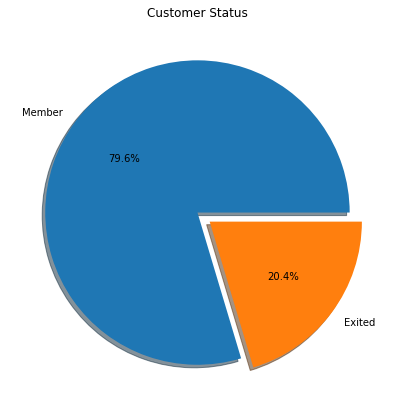

In [12]:
plt.figure(figsize=(7,7))
plt.pie(x=((df["Exited"].value_counts()*100) / len(df)), labels=['Member', 'Exited'], explode=(0,0.1), autopct='%1.1f%%', shadow=True)
plt.title("Customer Status")
plt.show()

<b>The above pie chart shows us the percentage of existing customers and those who have exited.<br>
    We would need to perform sampling on the data as the ratio of 1-to-0 is 1:4.<br>
    We will create a function that will allow us to create a model with and without sampling.

---

#### Feature - *IsActiveMember*

In [13]:
df["IsActiveMember"].value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

In [14]:
df[df["IsActiveMember"] == 0].head(6)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
10,528,France,Male,31,6,102016.72,2,0,0,80181.12,0
11,497,Spain,Male,24,3,0.00,2,1,0,76390.01,0


In [15]:
df[df["IsActiveMember"] == 1].head(6)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
6,822,France,Male,50,7,0.00,2,1,1,10062.80,0
8,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


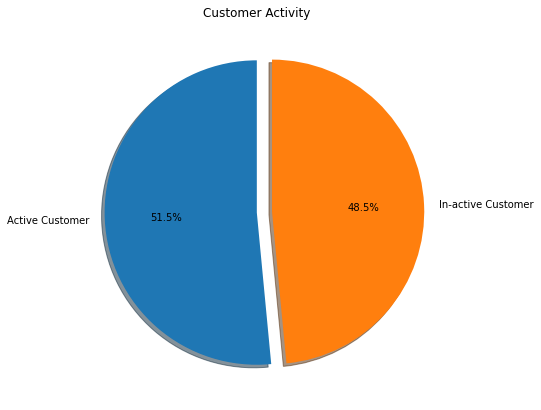

In [16]:
plt.figure(figsize=(7,7))
plt.pie(x=((df["IsActiveMember"].value_counts()*100) / len(df)), labels=['Active Customer', 'In-active Customer'], explode=(0,0.1), autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Customer Activity")
plt.show()

<b>The dataset also contains a feature that indicates the number of active and inactive members. It is not clear as to what this signifies about the customer.<br>
   * Could it mean that their account is now inactive as there has been no sort of activity (deposits/withdrawls/transfer between accounts) for a while?<br>
   * Or could it mean that the customer has signed up for some membership plan offered by the bank?

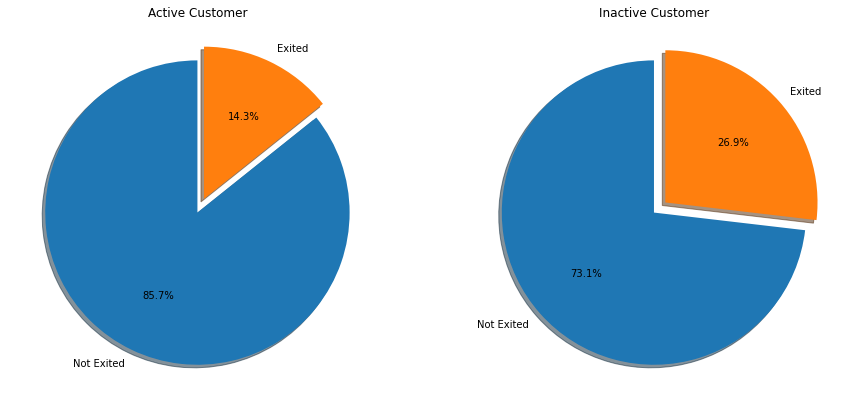

In [17]:
plt.figure(figsize=(15,15))
ax1 = plt.subplot2grid((1,2), (0, 0))
plt.pie(x=df[df["IsActiveMember"] == 1]["Exited"].value_counts(), labels=['Not Exited', 'Exited'], explode=(0,0.1), autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Active Customer")
ax2 = plt.subplot2grid((1,2), (0, 1))
plt.pie(x=df[df["IsActiveMember"] == 0]["Exited"].value_counts(), labels=['Not Exited', 'Exited'], explode=(0,0.1), autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Inactive Customer")
plt.show()

<b>The above two graphs show us the percentage of customers who have exited and who are still with the bank from the 'IsActiveMember' feature.

---

#### Numerical Features Distribution

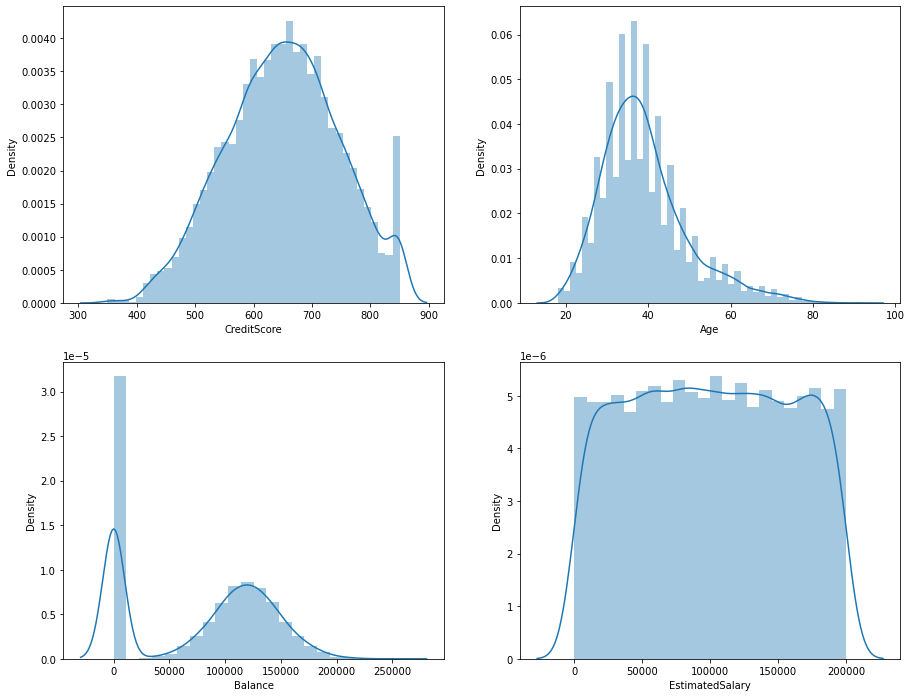

CreditScore     : -0.07159586676212397
Age             : 1.0111685586628079
Balance         : -0.14108754375291138
EstimatedSalary : 0.0020850448448748848


In [18]:
fig, ax_plot = plt.subplots(nrows=2, ncols=2, figsize=(15,12))
sns.distplot(df["CreditScore"], ax=ax_plot[0][0])
sns.distplot(df["Age"], ax=ax_plot[0][1])
sns.distplot(df["Balance"], ax=ax_plot[1][0])
sns.distplot(df["EstimatedSalary"], ax=ax_plot[1][1])
plt.show()

for each in df_num:
    print("{:<15} : {}" .format(each, skew(df[each])))

<b>There is some skewness in 'Balance', while 'Age' is skewed, but not very high. We can work with on this after creating the base model.

---

#### Numerical Features Summarization

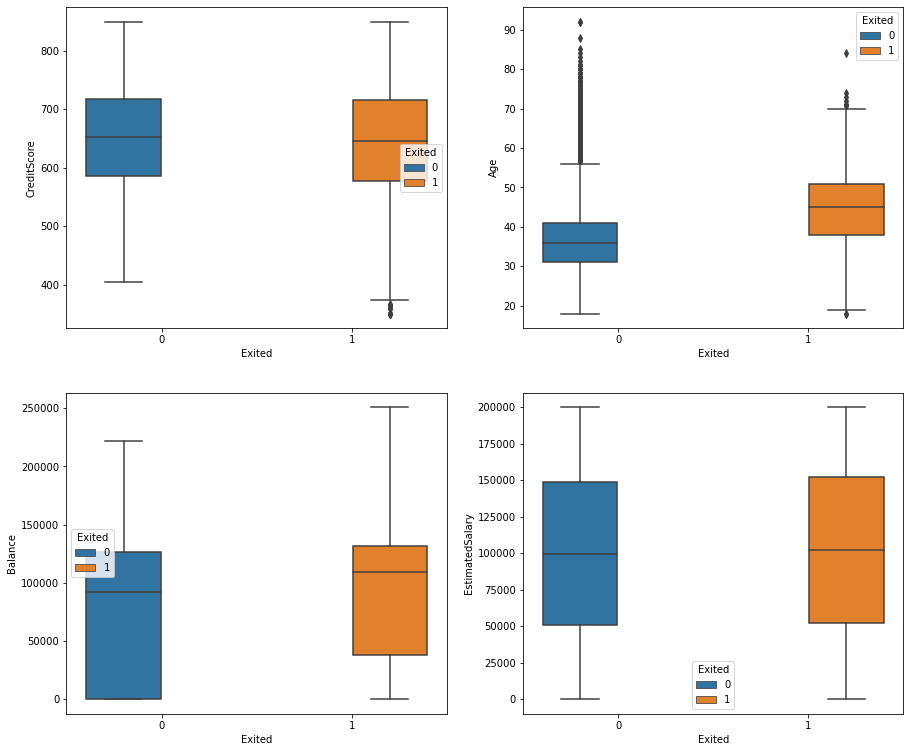

In [19]:
fig, ax_plot = plt.subplots(nrows=2, ncols=2, figsize=(15,13))
sns.boxplot(y='CreditScore', x='Exited', hue='Exited',data=df, ax=ax_plot[0][0])
sns.boxplot(y='Age', x='Exited', hue='Exited',data=df, ax=ax_plot[0][1])
sns.boxplot(y='Balance', x='Exited', hue='Exited',data=df, ax=ax_plot[1][0])
sns.boxplot(y='EstimatedSalary', x='Exited', hue='Exited',data=df, ax=ax_plot[1][1])
plt.show()

### Assumptions

#### 'Age' And 'Balance'
They do seem to influence whether a customer might exit or not. There is a bit of variance in the data of these two features, including the median.

#### 'CreditScore' and 'EstimatedSalary'
These features do not seem to have much influence over a customer exiting or not. The distribution for both seem to be normal, with some outliers in **'CreditScore'**.

---

#### Categorical Features

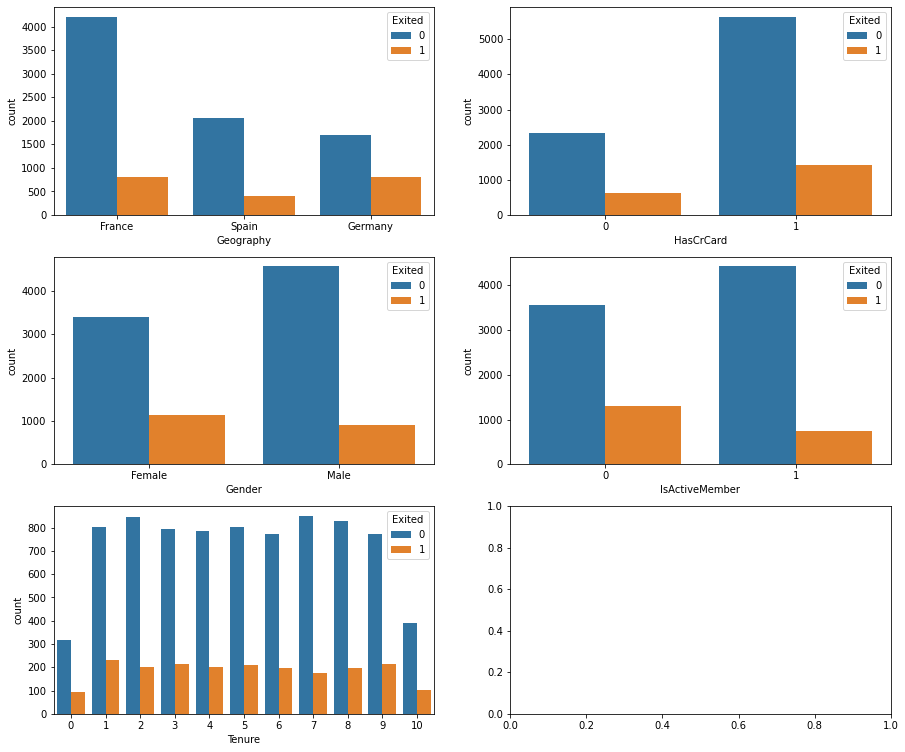

In [20]:
fig, ax_plot = plt.subplots(nrows=3, ncols=2, figsize=(15,13))
sns.countplot(x='Geography', hue='Exited',data=df, ax=ax_plot[0][0])
sns.countplot(x='Gender', hue='Exited',data=df, ax=ax_plot[1][0])
sns.countplot(x='HasCrCard', hue='Exited',data=df, ax=ax_plot[0][1])
sns.countplot(x='IsActiveMember', hue='Exited',data=df, ax=ax_plot[1][1])
sns.countplot(x='Tenure', hue='Exited',data=df, ax=ax_plot[2][0])
plt.show()

### Assumptions

#### Geography
Most of the bank customers are from France. And most of the French customers are still existing customers.<br>
The country with the lowest number of customers who have left is Spain.<br>

#### Credit Card Holder
A lot of the customers have credit cards. However, it would seem that this does not influence a customer to stay or exit.<br>

#### Gender
Overall, there are more Male customers. But the percentage of Female customers having exited is slightly more.<br>

#### Active Customer
From the total number of inactive customers, less than 50% of them had exited. From the existing active customers, and a lot of them have not exited. However, there are some active customers who have left the bank. Would this soon make them inactive?

<hr>

#### Features - *'EstimatedSalary'* & *'Balance'*

In [21]:
groups = ["Low", "Medium", "High"]

df["EstimatedSalary_Range"] = pd.qcut(df["EstimatedSalary"], q=3, labels=groups)
df[["EstimatedSalary", "EstimatedSalary_Range"]].head(10)

,EstimatedSalary,EstimatedSalary_Range
0,101348.88,Medium
1,112542.58,Medium
2,113931.57,Medium
3,93826.63,Medium
4,79084.10,Medium
5,149756.71,High
6,10062.80,Low
7,119346.88,Medium
8,74940.50,Medium
9,71725.73,Medium


In [22]:
df["Balance_Range"] = pd.qcut(df["Balance"], q=[.0,.5,.75,1.], labels=groups, duplicates="drop")
df[["Balance", "Balance_Range"]].head(10)

,Balance,Balance_Range
0,0.00,Low
1,83807.86,Low
2,159660.80,High
3,0.00,Low
4,125510.82,Medium
5,113755.78,Medium
6,0.00,Low
7,115046.74,Medium
8,142051.07,High
9,134603.88,High


In [23]:
df["EstimatedSalary_Range"].value_counts()

Low       3334
High      3333
Medium    3333
Name: EstimatedSalary_Range, dtype: int64

In [24]:
df["Balance_Range"].value_counts()

Low       5000
High      2500
Medium    2500
Name: Balance_Range, dtype: int64

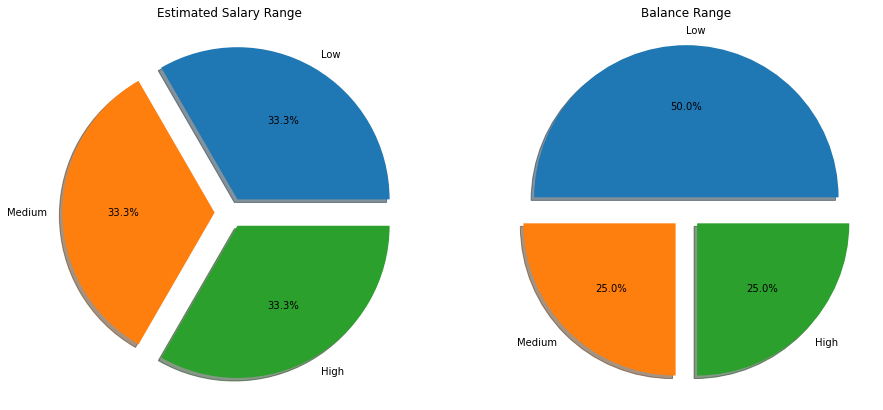

In [25]:
plt.subplots(figsize=(15,15))
plt.subplot2grid((1,2), (0,0))
plt.pie(x=df["EstimatedSalary_Range"].value_counts(), autopct='%1.1f%%', explode=(0.1,0.1,0.1), shadow=True, labels=["Low", "Medium", "High"])
plt.title("Estimated Salary Range")
plt.subplot2grid((1,2), (0,1))
plt.pie(x=df["Balance_Range"].value_counts(), autopct='%1.1f%%', explode=(0.1,0.1,0.1), shadow=True, labels=["Low", "Medium", "High"])
plt.title("Balance Range")
plt.show()

In [26]:
len(df[df["Balance"] == 0])

3617

In [27]:
df["Exited"][df["Balance"] == 0].value_counts()

0    3117
1     500
Name: Exited, dtype: int64

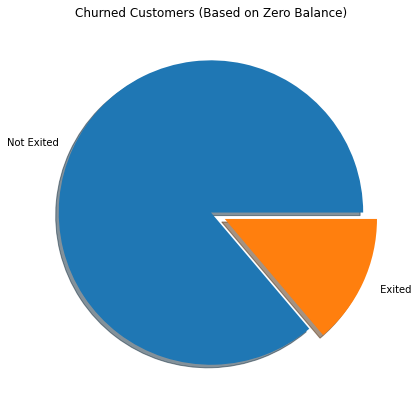

In [28]:
plt.figure(figsize=(7,7))
plt.pie(df["Exited"][df["Balance"] == 0].value_counts(), explode=(0,0.1), shadow=True, labels=["Not Exited", " Exited"])
plt.title("Churned Customers (Based on Zero Balance)")
plt.show()

High      2500
Medium    2500
Low       1383
Name: Balance_Range, dtype: int64



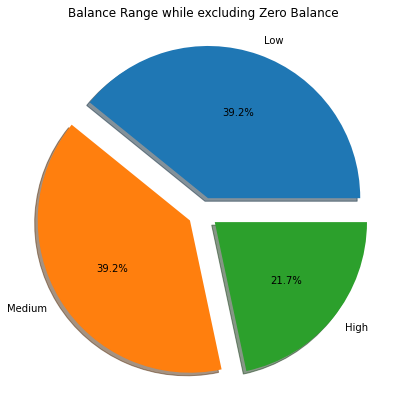

In [29]:
print(df[df["Balance"] > 0]["Balance_Range"].value_counts())
print()

plt.figure(figsize=(7,7))
plt.pie(df[df["Balance"] > 0]["Balance_Range"].value_counts(), explode=((0.1),(0.1),(0.1)), shadow=True, labels=["Low", "Medium", "High"], autopct="%1.1f%%")
plt.title("Balance Range while excluding Zero Balance")
plt.show()

### Assumptions

#### Estimated Salary Range
There seems to be an even distribution of customers with regards to the range of their salary.

#### Balance Range
50% of the customers have a low bank balance. A lot of these customers have a bank balance of **zero**. Are they new customers? Some of them have already exited.<br>
If we exclude all zero balance accounts, there is an even distribution of about 40% each between Low and Medium Balance accounts, while 20% of the accounts have a High Balance.

---

### Building the Neural Network Architecture

In [30]:
df.drop(["EstimatedSalary_Range", "Balance_Range"], axis=1, inplace=True)

In [31]:
for cols in df_cat:
    le = LabelEncoder()
    df[cols] = le.fit_transform(df[cols])

In [32]:
X = df.drop("Exited", axis=1)
y = df["Exited"]

#### Function to create Neural Network
* **nodes** - List of values for nodes per layer. Hidden layers created as per the length of 'nodes'.<br>
* **act** - Activating Function<br>
* **opt** - Optimizer<br>
* **loss_func** - Loss Function<br>
* **eps** - No. of Epochs<br> 
* **batch** - No. of samples per batch<br>
* **os** - OverSample

In [33]:
# Function to build the model

def nn_model(X, y, nodes, act, opt, loss_func, eps, batch=None, os="None"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)
    
    if not os=="None":
        x_os, y_os = os.fit_resample(X_train_ss, y_train)
    else:
        x_os, y_os = X_train_ss, y_train
    
    model = nn_layers(act,nodes)
    model.summary()

    print()
    
    print("\nBuilding NN Model\n")
    model.compile(optimizer=opt, loss=loss_func)
    trained_model = model.fit(x_os, y_os, epochs=eps, batch_size=batch)
   
    lines()
    
    print("Model Summary")
    plt.figure()
    plt.plot(trained_model.history['loss'])
    plt.show()
    
    lines()
    
    print("ROC Curve")
    auc_roc(X_test_ss, y_test, model)
    
    return [X_test_ss, y_test, model]

In [34]:
# Function to create the layers

def nn_layers(act, nodes):
    layers = [tf.keras.layers.Dense(3, activation=act, input_shape=(X.shape[1],))]

    for i in range(len(nodes)):
        if type(nodes[i]) == int:
            layers.append(tf.keras.layers.Dense(nodes[i], activation=act))
        else:
            layers.append(tf.keras.layers.Dropout(nodes[i]))

    layers.append(tf.keras.layers.Dense(1, activation="sigmoid"))
    
    model = tf.keras.Sequential(layers)
    
    return model

In [35]:
# Function for evaluating the model

def eval_model(X_test_ss, y_test, model, thres):
    y_pred = model.predict(X_test_ss)
    y_pred = np.where(y_pred > thres, 1, 0)
    print(classification_report(y_test, y_pred))

In [36]:
# Function to find the appropriate threshold using AUC-ROC

def auc_roc(X_test_ss, y_test, model):
    proba = model.predict_proba(X_test_ss)[:,-1]
    thresholds = np.arange(0.1, 1.0, 0.1)
    tprs, fprs = [], []
    
    for each in thresholds:
        y_pred = np.where(proba >= each, 1, 0)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tpr = tp/(tp + fn)
        fpr = fp/(fp + tn)
        tprs.append(tpr)
        fprs.append(fpr)

    plt.figure()
    plt.plot(fprs, tprs, "x--")
    plt.show()
    
    # fpr, tpr, thres = roc_curve(y_test, proba, pos_label=1)
    print("AUC ROC Score : ", roc_auc_score(y_test, proba))

In [37]:
def lines():
    print()
    print("_"*150)
    print()

<hr><hr>

# NN Models - Medium Complexity v1.0

The first models will be built with a medium amount of complexity.

### Base Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 33        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 49        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 48        
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 35        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6

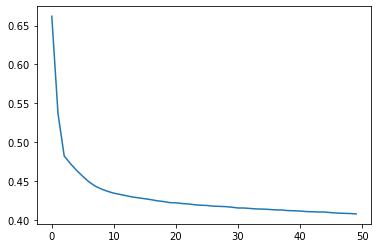


______________________________________________________________________________________________________________________________________________________

ROC Curve
Instructions for updating:
Please use `model.predict()` instead.


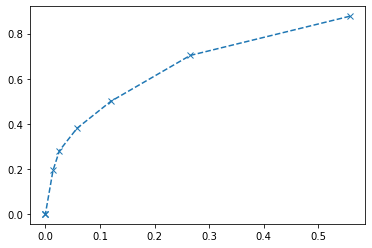

AUC ROC Score :  0.7833884792431601


In [38]:
nodes = [5,6,7,6,5]
result_01 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 50, 100)

In [39]:
eval_model(result_01[0], result_01[1], result_01[2], 0.3)

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      2373
           1       0.52      0.50      0.51       627

    accuracy                           0.80      3000
   macro avg       0.70      0.69      0.69      3000
weighted avg       0.80      0.80      0.80      3000



<hr>

### RandomOverSampler

In [40]:
over_sample = RandomOverSampler(sampling_strategy="minority", random_state=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 20        
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 36        
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 49        
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 48        
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 35        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

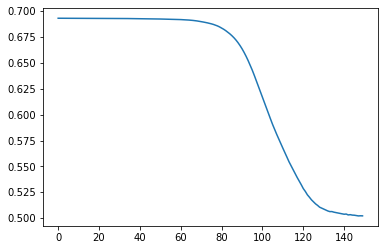


______________________________________________________________________________________________________________________________________________________

ROC Curve


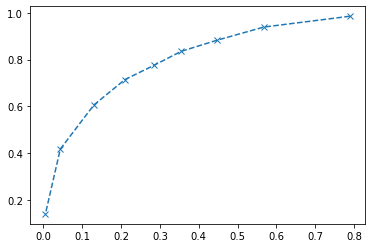

AUC ROC Score :  0.8357381117045766


In [41]:
result_02 = nn_model(X, y, nodes, "relu", "sgd", "binary_crossentropy", 150, 100, over_sample)

In [42]:
eval_model(result_02[0], result_02[1], result_02[2], 0.5)

              precision    recall  f1-score   support

           0       0.92      0.71      0.81      2373
           1       0.42      0.78      0.54       627

    accuracy                           0.73      3000
   macro avg       0.67      0.75      0.67      3000
weighted avg       0.82      0.73      0.75      3000



<hr>

### SMOTE

In [43]:
over_sample = SMOTE(sampling_strategy="minority", random_state=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 20        
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 36        
_________________________________________________________________
dense_17 (Dense)             (None, 7)                 49        
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 48        
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 35        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

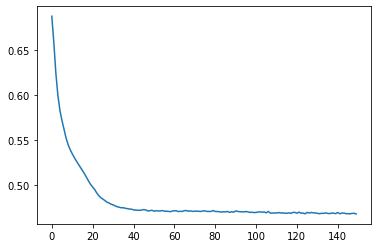


______________________________________________________________________________________________________________________________________________________

ROC Curve


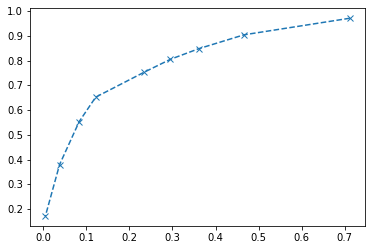

AUC ROC Score :  0.847656147609571


In [44]:
result_03 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 150, 100, over_sample)

In [45]:
eval_model(result_03[0], result_03[1], result_03[2], 0.5)

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      2373
           1       0.46      0.75      0.57       627

    accuracy                           0.76      3000
   macro avg       0.69      0.76      0.70      3000
weighted avg       0.82      0.76      0.78      3000



### Assumptions

The Recal score is the highest for the the RandomOverSampler model with medium complexity. However, we would prefer for a better score.
<ul>0.50 - Base (0.3)</ul>
<ul><b>0.78 - RandomOverSampler (0.5)</b></ul>
<ul>0.75 - SMOTE (0.5)</ul>

<hr>

# NN Models - High Complexity v1.0

In this iteration, we will build all three models with a higher complexity. To do this, we will increase the number of hidden layers and also the nodes within the hidden layers.

### *Base Model*

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 20        
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 36        
_________________________________________________________________
dense_24 (Dense)             (None, 7)                 49        
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 64        
_________________________________________________________________
dense_26 (Dense)             (None, 7)                 63        
_________________________________________________________________
dense_27 (Dense)             (None, 6)                

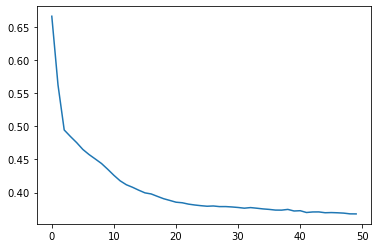


______________________________________________________________________________________________________________________________________________________

ROC Curve


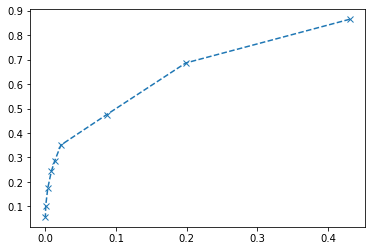

AUC ROC Score :  0.8311022931423491


In [46]:
nodes = [5,6,7,8,7,6,5,4]
result_10 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 50, 100)

In [47]:
eval_model(result_10[0], result_10[1], result_10[2], 0.3)

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2373
           1       0.59      0.48      0.53       627

    accuracy                           0.82      3000
   macro avg       0.73      0.69      0.71      3000
weighted avg       0.81      0.82      0.81      3000



In [48]:
eval_model(result_10[0], result_10[1], result_10[2], 0.2)

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      2373
           1       0.48      0.69      0.56       627

    accuracy                           0.78      3000
   macro avg       0.69      0.74      0.71      3000
weighted avg       0.82      0.78      0.79      3000



<hr>

## *RandomOverSampler*

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 20        
_________________________________________________________________
dense_33 (Dense)             (None, 6)                 36        
_________________________________________________________________
dense_34 (Dense)             (None, 7)                 49        
_________________________________________________________________
dense_35 (Dense)             (None, 8)                 64        
_________________________________________________________________
dense_36 (Dense)             (None, 7)                 63        
_________________________________________________________________
dense_37 (Dense)             (None, 6)                

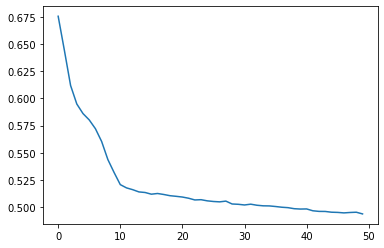


______________________________________________________________________________________________________________________________________________________

ROC Curve


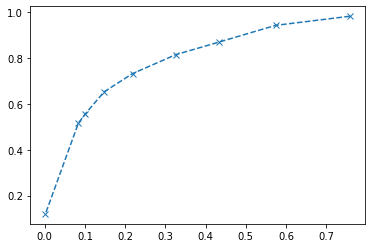

AUC ROC Score :  0.8356127648163045


In [49]:
over_sample = RandomOverSampler(sampling_strategy="minority", random_state=1)
result_11 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 50, 100, over_sample)

In [50]:
eval_model(result_11[0], result_11[1], result_11[2], 0.5)

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      2373
           1       0.47      0.73      0.57       627

    accuracy                           0.77      3000
   macro avg       0.69      0.76      0.71      3000
weighted avg       0.82      0.77      0.79      3000



<hr>

### *SMOTE*

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_42 (Dense)             (None, 5)                 20        
_________________________________________________________________
dense_43 (Dense)             (None, 6)                 36        
_________________________________________________________________
dense_44 (Dense)             (None, 7)                 49        
_________________________________________________________________
dense_45 (Dense)             (None, 8)                 64        
_________________________________________________________________
dense_46 (Dense)             (None, 7)                 63        
_________________________________________________________________
dense_47 (Dense)             (None, 6)                

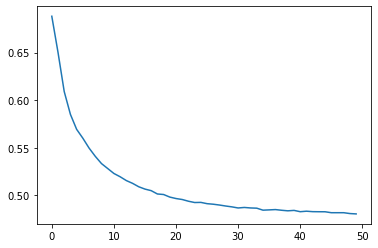


______________________________________________________________________________________________________________________________________________________

ROC Curve


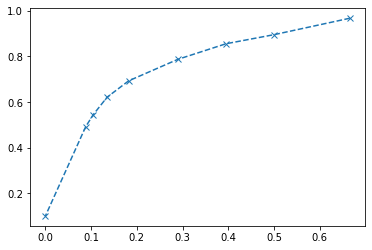

AUC ROC Score :  0.826390527135753


In [51]:
over_sample = SMOTE(sampling_strategy="minority", random_state=1)
result_12 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 50, 100, over_sample)

In [52]:
eval_model(result_12[0], result_12[1], result_12[2], 0.5)

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      2373
           1       0.50      0.69      0.58       627

    accuracy                           0.79      3000
   macro avg       0.71      0.76      0.72      3000
weighted avg       0.82      0.79      0.80      3000



### Assumptions

As we've increased the complexity, there has been some change with Recall scores. RandomOverSampler got the higher score. And we have taken two threshold values for the Base model.
<ul>0.48, 0.69 - Base (0.3, 0.2)</ul>
<ul><b>0.73 - RandomOverSampler (0.5)</b></ul>
<ul>0.69 - SMOTE (0.5)</ul>

<hr><hr>

# NN Models - Low Complexity v1.0

We will now create the models with very low complexity. There will be only one hidden layer in this architecture.

## *Base Model*

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_52 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 4         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


Building NN Model

Epoch 1/50
219/219 [==============================] - 0s 1ms/step - loss: 0.6153
Epoch 2/50
219/219 [==============================] - 0s 2ms/step - loss: 0.4977
Epoch 3/50
219/219 [==============================] - 0s 2ms/step - loss: 0.4699
Epoch 4/50
219/219 [==============================] - 0s 2ms/step - loss: 0.4590A: 0s - loss: 
Epoch 5/50
219/219 [=========

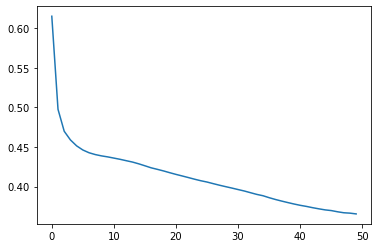


______________________________________________________________________________________________________________________________________________________

ROC Curve


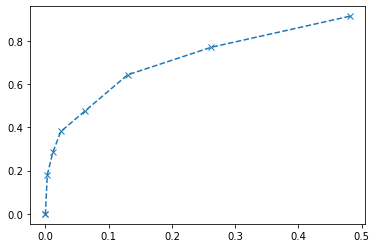

AUC ROC Score :  0.8453743637721282


In [53]:
nodes = [3]
result_20 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 50)

In [54]:
eval_model(result_20[0], result_20[1], result_20[2], 0.3)

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2373
           1       0.57      0.64      0.60       627

    accuracy                           0.82      3000
   macro avg       0.73      0.76      0.74      3000
weighted avg       0.83      0.82      0.83      3000



<hr>

## *RandomOverSampler*

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_55 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 4         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


Building NN Model

Epoch 1/150
350/350 [==============================] - 0s 1ms/step - loss: 0.6989
Epoch 2/150
350/350 [==============================] - 0s 1ms/step - loss: 0.6854
Epoch 3/150
350/350 [==============================] - 0s 1ms/step - loss: 0.6578
Epoch 4/150
350/350 [==============================] - 0s 1ms/step - loss: 0.6203
Epoch 5/150
350/350 [==================

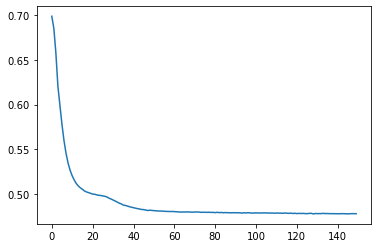


______________________________________________________________________________________________________________________________________________________

ROC Curve


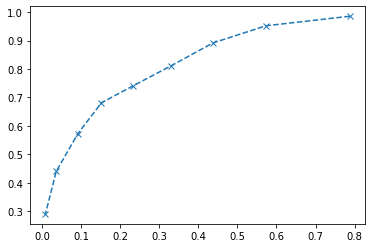

AUC ROC Score :  0.8486451446395554


In [55]:
over_sample = RandomOverSampler(sampling_strategy='minority', random_state=1)
result_21 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 150, os=over_sample)

In [56]:
eval_model(result_21[0], result_21[1], result_21[2], 0.5)

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      2373
           1       0.46      0.74      0.57       627

    accuracy                           0.76      3000
   macro avg       0.69      0.75      0.70      3000
weighted avg       0.82      0.76      0.78      3000



<hr>

## *SMOTE*

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_58 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 4         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


Building NN Model

Epoch 1/150
350/350 [==============================] - 0s 1ms/step - loss: 0.6818
Epoch 2/150
350/350 [==============================] - 0s 1ms/step - loss: 0.6494
Epoch 3/150
350/350 [==============================] - 0s 1ms/step - loss: 0.5873
Epoch 4/150
350/350 [==============================] - 0s 977us/step - loss: 0.5648
Epoch 5/150
350/350 [================

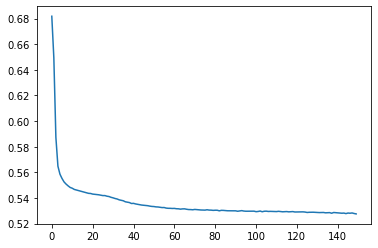


______________________________________________________________________________________________________________________________________________________

ROC Curve


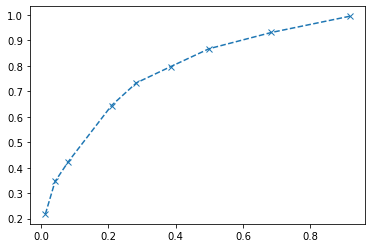

AUC ROC Score :  0.7958294099421253


In [57]:
over_sample = SMOTE(sampling_strategy='minority', random_state=1)
result_22 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 150, os=over_sample)

In [58]:
eval_model(result_22[0], result_22[1], result_22[2], 0.5)

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      2373
           1       0.41      0.73      0.52       627

    accuracy                           0.72      3000
   macro avg       0.66      0.73      0.66      3000
weighted avg       0.81      0.72      0.74      3000



### Assumptions

RandomOverSampler showed the same results as from the previous iteration.
<ul>0.63 - Base (0.5)</ul>
<ul><b>0.74 - RandomOverSampler (0.5)</b></ul>
<ul>0.73 - SMOTE (0.5)</ul>

---

# NN Models - Low Complexity v1.1

The models in this iteration will have two hidden layers.

## *Base Model*

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_61 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_62 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 4         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


Building NN Model

Epoch 1/50
219/219 [==============================] - 0s 911us/step - loss: 0.6720
Epoch 2/50
219/219 [==============================] - 0s 1ms/step - loss: 0.5565
Epoch 3/50
219/219 [==============================] - 0s 1ms/step - los

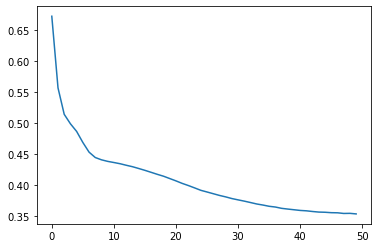


______________________________________________________________________________________________________________________________________________________

ROC Curve


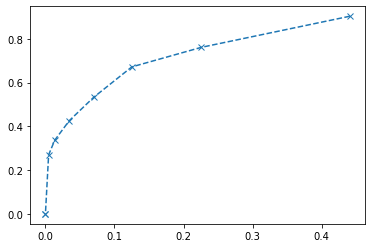

AUC ROC Score :  0.854921562420398


In [59]:
nodes = [3,3]
result_30 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 50)

In [60]:
eval_model(result_30[0], result_30[1], result_30[2], 0.3)

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      2373
           1       0.59      0.67      0.63       627

    accuracy                           0.83      3000
   macro avg       0.75      0.77      0.76      3000
weighted avg       0.84      0.83      0.84      3000



In [61]:
eval_model(result_30[0], result_30[1], result_30[2], 0.2)

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      2373
           1       0.47      0.76      0.58       627

    accuracy                           0.77      3000
   macro avg       0.70      0.77      0.71      3000
weighted avg       0.83      0.77      0.79      3000



---

## *RandomOverSampler*

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_65 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_66 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 4         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


Building NN Model

Epoch 1/150
350/350 [==============================] - 0s 884us/step - loss: 0.6947
Epoch 2/150
350/350 [==============================] - 0s 935us/step - loss: 0.6871
Epoch 3/150
350/350 [==============================] - 0s 931us/st

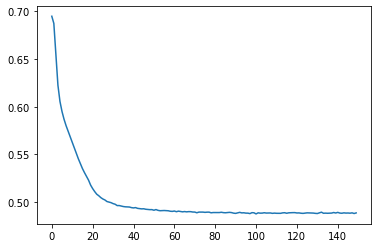


______________________________________________________________________________________________________________________________________________________

ROC Curve


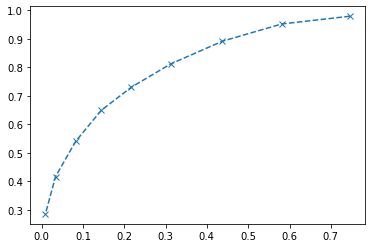

AUC ROC Score :  0.8443957843119463


In [62]:
over_sample = RandomOverSampler(sampling_strategy='minority', random_state=1)
result_31 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 150, os=over_sample)

In [63]:
eval_model(result_31[0], result_31[1], result_31[2], 0.5)

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      2373
           1       0.47      0.73      0.57       627

    accuracy                           0.77      3000
   macro avg       0.69      0.76      0.71      3000
weighted avg       0.82      0.77      0.79      3000



---

## *SMOTE*

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_69 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_70 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 4         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


Building NN Model

Epoch 1/150
350/350 [==============================] - 0s 947us/step - loss: 0.6881
Epoch 2/150
350/350 [==============================] - 0s 1ms/step - loss: 0.6575
Epoch 3/150
350/350 [==============================] - 0s 968us/step

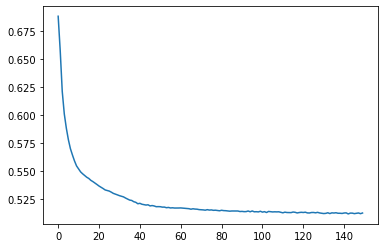


______________________________________________________________________________________________________________________________________________________

ROC Curve


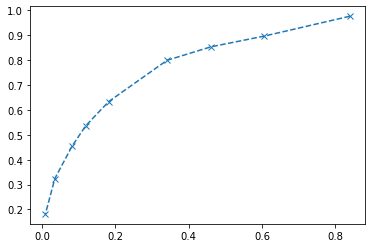

AUC ROC Score :  0.8013376159626743


In [64]:
over_sample = SMOTE(sampling_strategy='minority', random_state=1)
result_32 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 150, os=over_sample)

In [65]:
eval_model(result_32[0], result_32[1], result_32[2], 0.4)

              precision    recall  f1-score   support

           0       0.93      0.66      0.77      2373
           1       0.38      0.80      0.52       627

    accuracy                           0.69      3000
   macro avg       0.65      0.73      0.64      3000
weighted avg       0.81      0.69      0.72      3000



### Assumptions

In this iteration, we followed up after creating models with the lowest complexity. We slightly increased the complexity from one hidden layer to two hidden layers. The Recall scores seem to have bettered. SMOTE scored better.
<ul>0.67, 0.76 - Base (0.3, 0.2)</ul>
<ul>0.73 - RandomOverSampler (0.5)</ul>
<ul><b>0.80 - SMOTE (0.4)</b></ul>

---

# NN Models - Low Complexity v1.2

The models in this iteration will have three hidden layers.

## *Base Model*

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_73 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_74 (Dense)             (None, 5)                 20        
_________________________________________________________________
dense_75 (Dense)             (None, 3)                 18        
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 4         
Total params: 87
Trainable params: 87
Non-trainable params: 0
_________________________________________________________________


Building NN Model

Epoch 1/50
219/219 [==============================] - 0s 906us/step - loss: 0.6625
Epoch 2/50
219/219 

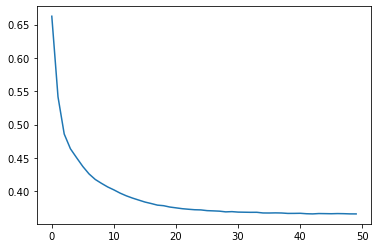


______________________________________________________________________________________________________________________________________________________

ROC Curve


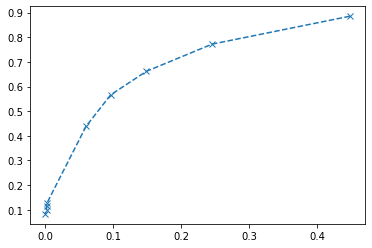

AUC ROC Score :  0.8397475318760833


In [66]:
nodes = [3,5,3]
result_40 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 50)

In [67]:
eval_model(result_40[0], result_40[1], result_40[2], 0.3)

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      2373
           1       0.54      0.66      0.59       627

    accuracy                           0.81      3000
   macro avg       0.72      0.76      0.74      3000
weighted avg       0.83      0.81      0.82      3000



---

## *RandomOverSampler*

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_78 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_79 (Dense)             (None, 5)                 20        
_________________________________________________________________
dense_80 (Dense)             (None, 3)                 18        
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 4         
Total params: 87
Trainable params: 87
Non-trainable params: 0
_________________________________________________________________


Building NN Model

Epoch 1/150
350/350 [==============================] - 0s 1ms/step - loss: 0.6661
Epoch 2/150
350/350 

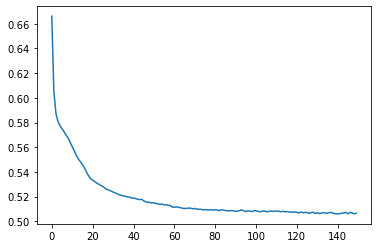


______________________________________________________________________________________________________________________________________________________

ROC Curve


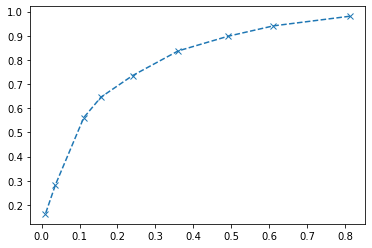

AUC ROC Score :  0.8249596235157484


In [68]:
over_sample = RandomOverSampler(sampling_strategy='minority', random_state=1)
result_41 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 150, os=over_sample)

In [69]:
eval_model(result_41[0], result_41[1], result_41[2], 0.5)

              precision    recall  f1-score   support

           0       0.92      0.76      0.83      2373
           1       0.45      0.74      0.56       627

    accuracy                           0.76      3000
   macro avg       0.68      0.75      0.69      3000
weighted avg       0.82      0.76      0.77      3000



---

## *SMOTE*

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_83 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_84 (Dense)             (None, 5)                 20        
_________________________________________________________________
dense_85 (Dense)             (None, 3)                 18        
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 4         
Total params: 87
Trainable params: 87
Non-trainable params: 0
_________________________________________________________________


Building NN Model

Epoch 1/150
350/350 [==============================] - 0s 975us/step - loss: 0.6936
Epoch 2/150
350/35

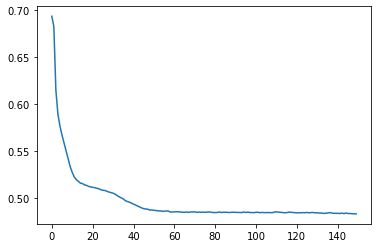


______________________________________________________________________________________________________________________________________________________

ROC Curve


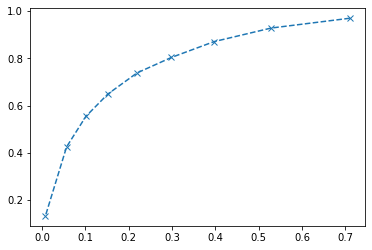

AUC ROC Score :  0.8364770870592948


In [70]:
over_sample = SMOTE(sampling_strategy='minority', random_state=1)
result_42 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 150, os=over_sample)

In [71]:
eval_model(result_42[0], result_42[1], result_42[2], 0.5)

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      2373
           1       0.47      0.74      0.58       627

    accuracy                           0.77      3000
   macro avg       0.69      0.76      0.71      3000
weighted avg       0.83      0.77      0.79      3000



### Assumptions

Once again, we slightly increased the complexity from two hidden layer to three hidden layers. RandomOverSampler and SMOTE scored the same.
<ul>0.66 - Base (0.3)</ul>
<ul><b>0.74 - RandomOverSampler (0.5)</b></ul>
<ul><b>0.74 - SMOTE (0.5)</b></ul>

---
---

# Models with Dropout

We will proceed with building the same previous models, however, here we will add dropout to see if we can get better results.

## NN Models - Medium Complexity v2.0

The first models will be built with a medium amount of complexity, with dropout. 

### Base Model

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_88 (Dense)             (None, 5)                 20        
_________________________________________________________________
dense_89 (Dense)             (None, 6)                 36        
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense_90 (Dense)             (None, 8)                 56        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_91 (Dense)             (None, 6)               

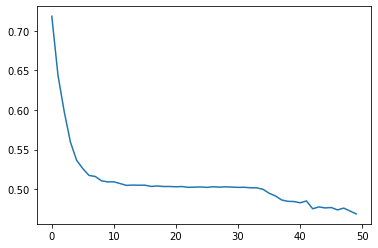


______________________________________________________________________________________________________________________________________________________

ROC Curve


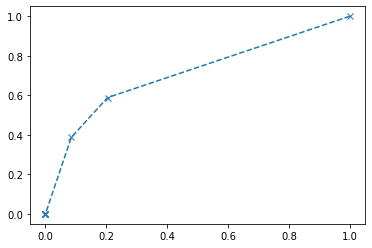

AUC ROC Score :  0.7459141283081665


In [72]:
nodes = [5,6,0.5,8,0.5,6,0.5,5]
result_01 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 50, 100)

In [73]:
eval_model(result_01[0], result_01[1], result_01[2], 0.3)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2373
           1       0.55      0.39      0.45       627

    accuracy                           0.80      3000
   macro avg       0.70      0.65      0.67      3000
weighted avg       0.79      0.80      0.79      3000



In [74]:
eval_model(result_01[0], result_01[1], result_01[2], 0.2)

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      2373
           1       0.43      0.59      0.50       627

    accuracy                           0.75      3000
   macro avg       0.66      0.69      0.67      3000
weighted avg       0.79      0.75      0.77      3000



<hr>

### RandomOverSampler

In [75]:
over_sample = RandomOverSampler(sampling_strategy="minority", random_state=1)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_95 (Dense)             (None, 5)                 20        
_________________________________________________________________
dense_96 (Dense)             (None, 6)                 36        
_________________________________________________________________
dropout_3 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_97 (Dense)             (None, 8)                 56        
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_98 (Dense)             (None, 6)               

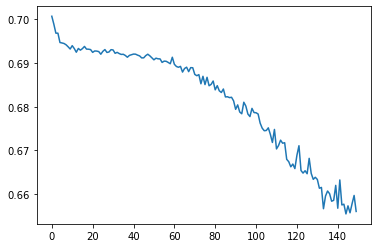


______________________________________________________________________________________________________________________________________________________

ROC Curve


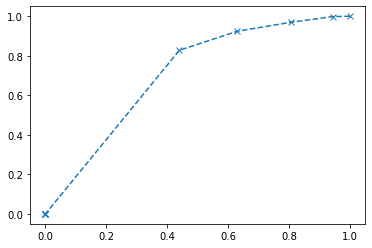

AUC ROC Score :  0.7420189653538513


In [76]:
result_02 = nn_model(X, y, nodes, "relu", "sgd", "binary_crossentropy", 150, 100, over_sample)

In [77]:
eval_model(result_02[0], result_02[1], result_02[2], 0.5)

              precision    recall  f1-score   support

           0       0.92      0.56      0.70      2373
           1       0.33      0.83      0.47       627

    accuracy                           0.62      3000
   macro avg       0.63      0.69      0.59      3000
weighted avg       0.80      0.62      0.65      3000



<hr>

### SMOTE

In [78]:
over_sample = SMOTE(sampling_strategy="minority", random_state=1)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 3)                 33        
_________________________________________________________________
dense_102 (Dense)            (None, 5)                 20        
_________________________________________________________________
dense_103 (Dense)            (None, 6)                 36        
_________________________________________________________________
dropout_6 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_104 (Dense)            (None, 8)                 56        
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_105 (Dense)            (None, 6)               

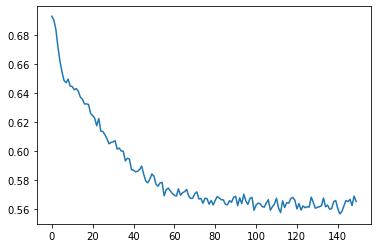


______________________________________________________________________________________________________________________________________________________

ROC Curve


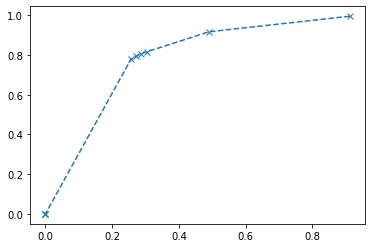

AUC ROC Score :  0.8045401785504254


In [79]:
result_03 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 150, 100, over_sample)

In [80]:
eval_model(result_03[0], result_03[1], result_03[2], 0.6)

              precision    recall  f1-score   support

           0       0.93      0.74      0.83      2373
           1       0.45      0.78      0.57       627

    accuracy                           0.75      3000
   macro avg       0.69      0.76      0.70      3000
weighted avg       0.83      0.75      0.77      3000



### Assumptions

The Recall score is the highest for the the RandomOverSampler model with medium complexity and dropout. 
<ul>0.39, 0.59 - Base (0.3, 0.2)</ul>
<ul><b>0.83 - RandomOverSampler (0.5)</b></ul>
<ul>0.78 - SMOTE (0.6)</ul>

<hr>

# NN Models - High Complexity v2.0

In this iteration, we will build all three models with a higher complexity, with dropout.

### *Base Model*

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 3)                 33        
_________________________________________________________________
dense_109 (Dense)            (None, 5)                 20        
_________________________________________________________________
dense_110 (Dense)            (None, 6)                 36        
_________________________________________________________________
dropout_9 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_111 (Dense)            (None, 7)                 49        
_________________________________________________________________
dense_112 (Dense)            (None, 8)                 64        
_________________________________________________________________
dropout_10 (Dropout)         (None, 8)               

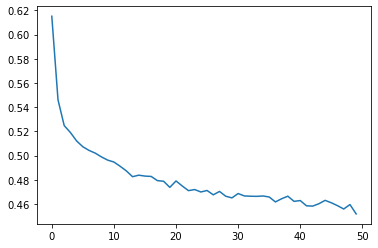


______________________________________________________________________________________________________________________________________________________

ROC Curve


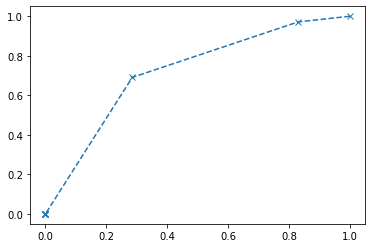

AUC ROC Score :  0.741381813342689


In [81]:
nodes = [5,6,0.5,7,8,0.5,7,6,0.5,5,4]
result_10 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 50, 100)

In [82]:
eval_model(result_10[0], result_10[1], result_10[2], 0.3)

              precision    recall  f1-score   support

           0       0.90      0.71      0.80      2373
           1       0.39      0.69      0.50       627

    accuracy                           0.71      3000
   macro avg       0.64      0.70      0.65      3000
weighted avg       0.79      0.71      0.73      3000



<hr>

## *RandomOverSampler*

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 3)                 33        
_________________________________________________________________
dense_119 (Dense)            (None, 5)                 20        
_________________________________________________________________
dense_120 (Dense)            (None, 6)                 36        
_________________________________________________________________
dropout_12 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_121 (Dense)            (None, 7)                 49        
_________________________________________________________________
dense_122 (Dense)            (None, 8)                 64        
_________________________________________________________________
dropout_13 (Dropout)         (None, 8)               

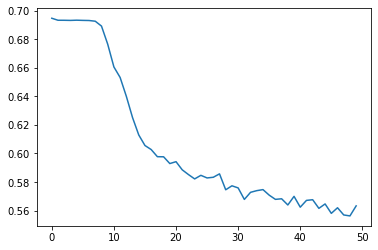


______________________________________________________________________________________________________________________________________________________

ROC Curve


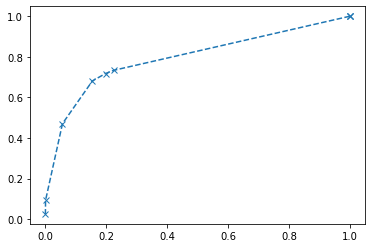

AUC ROC Score :  0.8152212120540021


In [83]:
over_sample = RandomOverSampler(sampling_strategy="minority", random_state=1)
result_11 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 50, 100, over_sample)

In [84]:
eval_model(result_11[0], result_11[1], result_11[2], 0.4)

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      2373
           1       0.46      0.73      0.57       627

    accuracy                           0.77      3000
   macro avg       0.69      0.75      0.70      3000
weighted avg       0.82      0.77      0.78      3000



<hr>

### *SMOTE*

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_128 (Dense)            (None, 3)                 33        
_________________________________________________________________
dense_129 (Dense)            (None, 5)                 20        
_________________________________________________________________
dense_130 (Dense)            (None, 6)                 36        
_________________________________________________________________
dropout_15 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_131 (Dense)            (None, 7)                 49        
_________________________________________________________________
dense_132 (Dense)            (None, 8)                 64        
_________________________________________________________________
dropout_16 (Dropout)         (None, 8)               

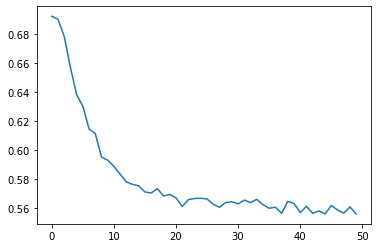


______________________________________________________________________________________________________________________________________________________

ROC Curve


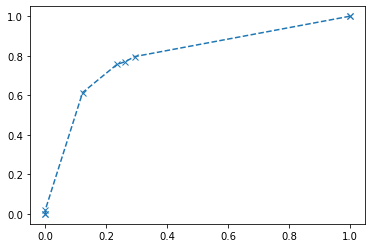

AUC ROC Score :  0.819171823363719


In [85]:
over_sample = SMOTE(sampling_strategy="minority", random_state=1)
result_12 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 50, 100, over_sample)

In [86]:
eval_model(result_12[0], result_12[1], result_12[2], 0.4)

              precision    recall  f1-score   support

           0       0.92      0.74      0.82      2373
           1       0.44      0.77      0.56       627

    accuracy                           0.74      3000
   macro avg       0.68      0.75      0.69      3000
weighted avg       0.82      0.74      0.77      3000



### Assumptions

The scores have dropped a bit after increasing the model complexity.
<ul>0.69 - Base (0.3)</ul>
<ul>0.73 - RandomOverSampler (0.4)</ul>
<ul><b>0.77 - SMOTE (0.4)</b></ul>

<hr>

# NN Models - Low Complexity v2.0

We will now create the models with very low complexity, and with dropout.

## *Base Model*

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138 (Dense)            (None, 3)                 33        
_________________________________________________________________
dense_139 (Dense)            (None, 6)                 24        
_________________________________________________________________
dropout_18 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_140 (Dense)            (None, 1)                 7         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


Building NN Model

Epoch 1/50
219/219 [==============================] - 0s 1ms/step - loss: 0.6419
Epoch 2/50
219/219 [==============================] - 0s 1ms/step - loss: 0.5519
Epoch 3/50
219/219 [==============================] - 0s 1ms/step - loss

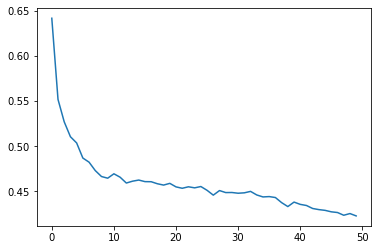


______________________________________________________________________________________________________________________________________________________

ROC Curve


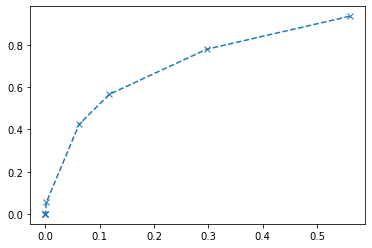

AUC ROC Score :  0.8258340272779026


In [87]:
nodes = [6,0.5]
result_20 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 50)

In [88]:
eval_model(result_20[0], result_20[1], result_20[2], 0.3)

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2373
           1       0.56      0.57      0.56       627

    accuracy                           0.82      3000
   macro avg       0.72      0.72      0.72      3000
weighted avg       0.82      0.82      0.82      3000



In [89]:
eval_model(result_20[0], result_20[1], result_20[2], 0.2)

              precision    recall  f1-score   support

           0       0.92      0.70      0.80      2373
           1       0.41      0.78      0.54       627

    accuracy                           0.72      3000
   macro avg       0.67      0.74      0.67      3000
weighted avg       0.82      0.72      0.74      3000



<hr>

## *RandomOverSampler*

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_141 (Dense)            (None, 3)                 33        
_________________________________________________________________
dense_142 (Dense)            (None, 6)                 24        
_________________________________________________________________
dropout_19 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_143 (Dense)            (None, 1)                 7         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


Building NN Model

Epoch 1/150
350/350 [==============================] - 0s 1ms/step - loss: 0.6999
Epoch 2/150
350/350 [==============================] - 0s 1ms/step - loss: 0.6574
Epoch 3/150
350/350 [==============================] - 0s 1ms/step - l

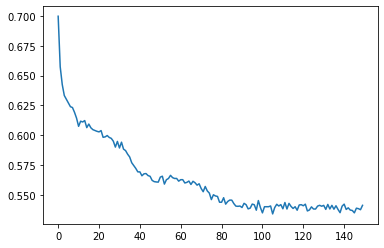


______________________________________________________________________________________________________________________________________________________

ROC Curve


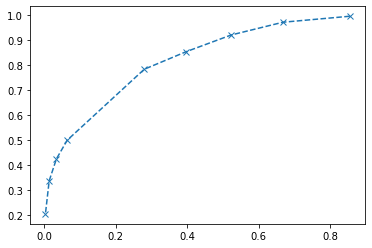

AUC ROC Score :  0.842572037495186


In [90]:
over_sample = RandomOverSampler(sampling_strategy='minority', random_state=1)
result_21 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 150, os=over_sample)

In [91]:
eval_model(result_21[0], result_21[1], result_21[2], 0.5)

              precision    recall  f1-score   support

           0       0.93      0.72      0.81      2373
           1       0.43      0.78      0.55       627

    accuracy                           0.73      3000
   macro avg       0.68      0.75      0.68      3000
weighted avg       0.82      0.73      0.76      3000



<hr>

## *SMOTE*

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 3)                 33        
_________________________________________________________________
dense_145 (Dense)            (None, 6)                 24        
_________________________________________________________________
dropout_20 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_146 (Dense)            (None, 1)                 7         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


Building NN Model

Epoch 1/150
350/350 [==============================] - 0s 997us/step - loss: 0.7164
Epoch 2/150
350/350 [==============================] - 0s 1ms/step - loss: 0.6849
Epoch 3/150
350/350 [==============================] - 0s 1ms/step -

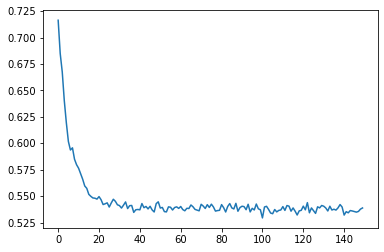


______________________________________________________________________________________________________________________________________________________

ROC Curve


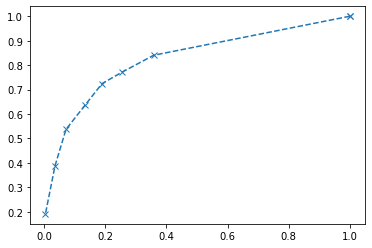

AUC ROC Score :  0.8305390722717225


In [92]:
over_sample = SMOTE(sampling_strategy='minority', random_state=1)
result_22 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 150, os=over_sample)

In [93]:
eval_model(result_22[0], result_22[1], result_22[2], 0.3)

              precision    recall  f1-score   support

           0       0.94      0.64      0.76      2373
           1       0.38      0.84      0.53       627

    accuracy                           0.68      3000
   macro avg       0.66      0.74      0.64      3000
weighted avg       0.82      0.68      0.71      3000



### Assumptions

Lowering the compexity has improve the scores.
<ul>0.57, 0.78 - Base (0.3, 0.2)</ul>
<ul>0.78 - RandomOverSampler (0.5)</ul>
<ul><b>0.84 - SMOTE (0.3)</b></ul>

---

# NN Models - Low Complexity v2.1

The models in this iteration will have two hidden layers.

## *Base Model*

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 3)                 33        
_________________________________________________________________
dense_148 (Dense)            (None, 6)                 24        
_________________________________________________________________
dropout_21 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_149 (Dense)            (None, 4)                 28        
_________________________________________________________________
dropout_22 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_150 (Dense)            (None, 1)                 5         
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________

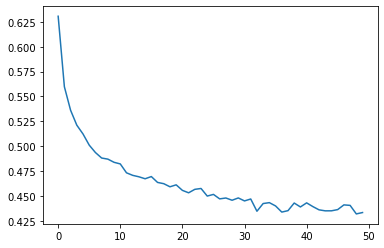


______________________________________________________________________________________________________________________________________________________

ROC Curve


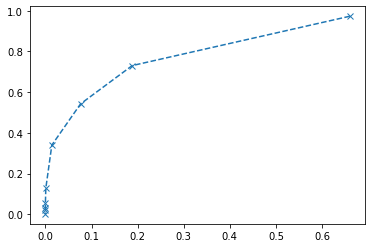

AUC ROC Score :  0.8497725945327249


In [94]:
nodes = [6,0.5,4,0.5]
result_30 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 50)

In [95]:
eval_model(result_30[0], result_30[1], result_30[2], 0.3)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2373
           1       0.65      0.54      0.59       627

    accuracy                           0.84      3000
   macro avg       0.77      0.73      0.75      3000
weighted avg       0.84      0.84      0.84      3000



In [96]:
eval_model(result_30[0], result_30[1], result_30[2], 0.2)

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      2373
           1       0.51      0.73      0.60       627

    accuracy                           0.79      3000
   macro avg       0.71      0.77      0.73      3000
weighted avg       0.83      0.79      0.81      3000



---

## *RandomOverSampler*

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_155 (Dense)            (None, 3)                 33        
_________________________________________________________________
dense_156 (Dense)            (None, 6)                 24        
_________________________________________________________________
dropout_25 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_157 (Dense)            (None, 4)                 28        
_________________________________________________________________
dropout_26 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_158 (Dense)            (None, 1)                 5         
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________

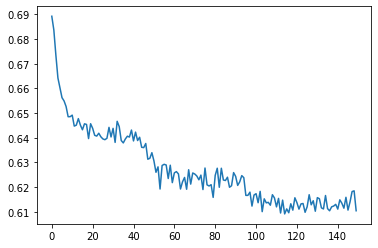


______________________________________________________________________________________________________________________________________________________

ROC Curve


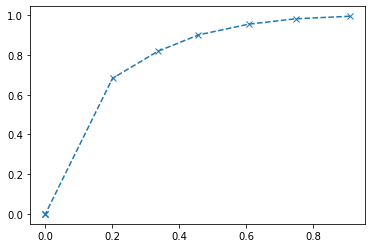

AUC ROC Score :  0.8070948355065728


In [98]:
over_sample = RandomOverSampler(sampling_strategy='minority', random_state=1)
result_31 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 150, os=over_sample)

In [99]:
eval_model(result_31[0], result_31[1], result_31[2], 0.6)

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      2373
           1       0.47      0.68      0.56       627

    accuracy                           0.78      3000
   macro avg       0.69      0.74      0.70      3000
weighted avg       0.81      0.78      0.79      3000



---

## *SMOTE*

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_159 (Dense)            (None, 3)                 33        
_________________________________________________________________
dense_160 (Dense)            (None, 6)                 24        
_________________________________________________________________
dropout_27 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_161 (Dense)            (None, 4)                 28        
_________________________________________________________________
dropout_28 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 5         
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________

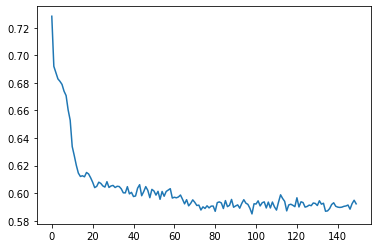


______________________________________________________________________________________________________________________________________________________

ROC Curve


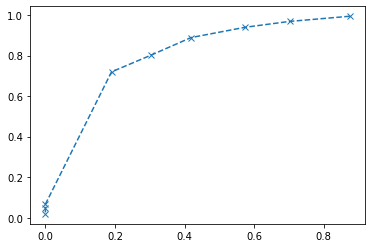

AUC ROC Score :  0.8244468102409417


In [100]:
over_sample = SMOTE(sampling_strategy='minority', random_state=1)
result_32 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 150, os=over_sample)

In [101]:
eval_model(result_32[0], result_32[1], result_32[2], 0.6)

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      2373
           1       0.50      0.72      0.59       627

    accuracy                           0.79      3000
   macro avg       0.71      0.76      0.72      3000
weighted avg       0.83      0.79      0.80      3000



### Assumptions

The scores have dropped in this iteration.
<ul>0.54, 0.73 - Base (0.3, 0.2)</ul>
<ul>0.68 - RandomOverSampler (0.6)</ul>
<ul><b>0.72 - SMOTE (0.6)</b></ul>

---

# NN Models - Low Complexity v2.2

The models in this iteration will have three hidden layers, with dropout

## *Base Model*

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_168 (Dense)            (None, 3)                 33        
_________________________________________________________________
dense_169 (Dense)            (None, 3)                 12        
_________________________________________________________________
dense_170 (Dense)            (None, 8)                 32        
_________________________________________________________________
dropout_30 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_171 (Dense)            (None, 3)                 27        
_________________________________________________________________
dense_172 (Dense)            (None, 1)                 4         
Total params: 108
Trainable params: 108
Non-trainable params: 0
_______________________________________________________

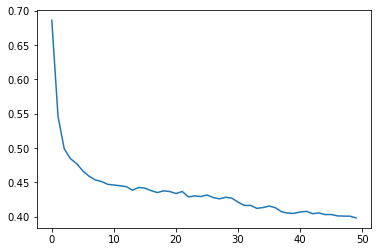


______________________________________________________________________________________________________________________________________________________

ROC Curve


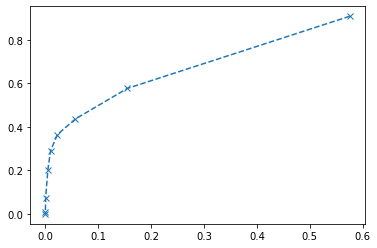

AUC ROC Score :  0.8094334119019727


In [103]:
nodes = [3,8,0.5,3]
result_40 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 50)

In [104]:
eval_model(result_40[0], result_40[1], result_40[2], 0.2)

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2373
           1       0.50      0.58      0.53       627

    accuracy                           0.79      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.80      0.79      0.79      3000



---

## *RandomOverSampler*

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_173 (Dense)            (None, 3)                 33        
_________________________________________________________________
dense_174 (Dense)            (None, 3)                 12        
_________________________________________________________________
dense_175 (Dense)            (None, 8)                 32        
_________________________________________________________________
dropout_31 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_176 (Dense)            (None, 3)                 27        
_________________________________________________________________
dense_177 (Dense)            (None, 1)                 4         
Total params: 108
Trainable params: 108
Non-trainable params: 0
_______________________________________________________

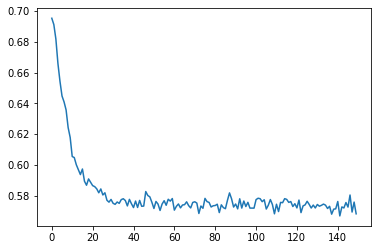


______________________________________________________________________________________________________________________________________________________

ROC Curve


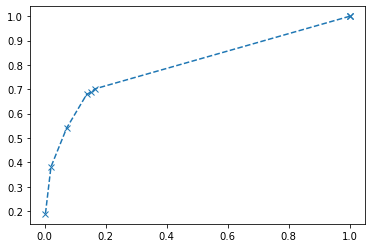

AUC ROC Score :  0.8017408767292324


In [105]:
over_sample = RandomOverSampler(sampling_strategy='minority', random_state=1)
result_41 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 150, os=over_sample)

In [106]:
eval_model(result_41[0], result_41[1], result_41[2], 0.4)

              precision    recall  f1-score   support

           0       0.91      0.83      0.87      2373
           1       0.53      0.70      0.60       627

    accuracy                           0.81      3000
   macro avg       0.72      0.77      0.74      3000
weighted avg       0.83      0.81      0.82      3000



---

## *SMOTE*

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_178 (Dense)            (None, 3)                 33        
_________________________________________________________________
dense_179 (Dense)            (None, 3)                 12        
_________________________________________________________________
dense_180 (Dense)            (None, 8)                 32        
_________________________________________________________________
dropout_32 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_181 (Dense)            (None, 3)                 27        
_________________________________________________________________
dense_182 (Dense)            (None, 1)                 4         
Total params: 108
Trainable params: 108
Non-trainable params: 0
_______________________________________________________

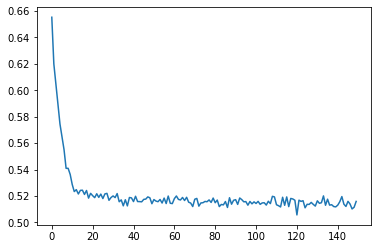


______________________________________________________________________________________________________________________________________________________

ROC Curve


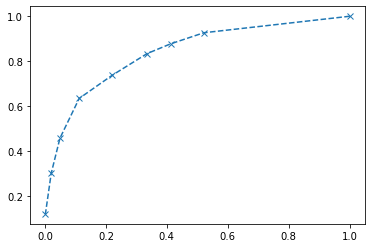

AUC ROC Score :  0.8438255063779051


In [107]:
over_sample = SMOTE(sampling_strategy='minority', random_state=1)
result_42 = nn_model(X, y, nodes, "relu", "adam", "binary_crossentropy", 150, os=over_sample)

In [108]:
eval_model(result_42[0], result_42[1], result_42[2], 0.5)

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      2373
           1       0.47      0.74      0.57       627

    accuracy                           0.77      3000
   macro avg       0.69      0.76      0.71      3000
weighted avg       0.82      0.77      0.79      3000



### Assumptions

Once again, we slightly increased the complexity from two hidden layer to three hidden layers. The AUC ROC scores reduced once more. The AUC ROC score for RandomOverSampler and SMOTE are almost the same.
<ul>0.58 - Base (0.2)</ul>
<ul>0.70 - RandomOverSampler (0.4)</ul>
<ul><b>0.74 - SMOTE (0.5)</b></ul>

---
---

# Conclusion

The goal of this project is to create a model that would predict the likelihood of a bank customer exiting the bank.

### *Version 1.0*
EDA and preprocessing. Base models with and without oversampling created.<br>

### *Version 2.0*
Definitions created.<br>
Seaborn plotted within grids.<br>

### *Version 3.0*
Identifying threshold using AUC-ROC. The value picked would have a high TPR value with a low FPR.<br>

### *Version 4.0*
Ran multiple iterations to achieve the best model.<br>

### *Version 5.0*
Repeated running the same models, however, dropout was added. 

---
---
---